# Simple Classifiers


## <span style="color: yellowgreen;">1. </span> Importing Libraries


First, we will import all the necessary libraries.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif

## <span style="color: yellowgreen;">2. </span> Defining Classifiers


We define the classifiers that will be used for data classification.


In [19]:
# Define classifiers
classifiers = {
    "RandomForest": RandomForestClassifier(n_estimators=100),
    # "DecisionTree": DecisionTreeClassifier(max_depth=5),
    "SVM": SVC(kernel="poly", probability=True),
    "KNN": KNeighborsClassifier(
        n_neighbors=5
    ),  # kernel: ((...) -> Any) | Literal['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
    # "NeuralNet": MLPClassifier(alpha=1, max_iter=1000),
    "NaiveBayes": GaussianNB(),
}

## <span style="color: yellowgreen;">3. </span> Loading Data


We load the data from the CSV file, separate features from labels, and define the class names.


In [20]:
# Load data
data2 = np.genfromtxt("../../data/labels_features.csv", delimiter=",")
data2 = data2[1:, :]  # Assuming first row is header

# Separate features and labels
LABELS = data2[:, 1].astype(int)  # Assuming class labels are in the second column
FEATURES = data2[:, 2:]  # Assuming features start from the third column

# Define target names
TARGET_NAMES = ["Metastasis, class 0", "No metastasis, class 1"]

## <span style="color: yellowgreen;">4. </span> Initializing Metrics


We create dictionaries to store the metric results for each classifier.


In [21]:
# Initialize metrics
accuracy_scores = {name: [] for name in classifiers}
precision_scores = {name: [] for name in classifiers}
recall_scores = {name: [] for name in classifiers}
f1_scores = {name: [] for name in classifiers}
conf_matrices = {name: None for name in classifiers}

## <span style="color: yellowgreen;">5. </span> Stratified K-Fold Cross-Validation & Feature Selection


We use Stratified K-Fold for cross-validation, train models, and calculate metrics.

To calculate the standard deviation of the results of the classifiers, we need to do some training and testing of the models on different subdivisions of the data to get different results from which to calculate the standard deviation.

The code uses `StratifiedKFold` to split the data into multiple subsets and then calculates the mean metrics and standard deviation for each subset.

**Ranking Method for Feature Selection**:
The ranking method involves assigning a score or weight to each feature based on a specific criterion, such as correlation with the target or a test statistic (e.g., chi-squared, f_classif). Features with the highest scores are then selected for modeling.

In [22]:
# Perform Stratified K-Fold Cross-Validation
skf_splits = 5
skf = StratifiedKFold(n_splits=skf_splits, shuffle=True, random_state=42)

# Define the model for feature selection
model_rf = RandomForestClassifier(random_state=42)

# Create a pipeline with feature selection and model
pipeline = Pipeline(
    [("feature_selection", SelectKBest(score_func=f_classif)), ("classifier", model_rf)]
)

# Define the grid of parameters
param_grid = {
    "feature_selection__k": [5, 10, 15, 20, 25, 30]  # Adjust the range as needed
}

for train_index, test_index in skf.split(FEATURES, LABELS):
    X_train, X_test = FEATURES[train_index], FEATURES[test_index]
    y_train, y_test = LABELS[train_index], LABELS[test_index]

    # Perform grid search to find the best number of features
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="f1")
    grid_search.fit(X_train, y_train)

    # Get the best parameter for k
    best_k = grid_search.best_params_["feature_selection__k"]
    print(f"Best k: {best_k}")

    # Select the best features using the optimal k
    selector = SelectKBest(score_func=f_classif, k=best_k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    for name, clf in classifiers.items():
        clf.fit(X_train_selected, y_train)
        y_pred = clf.predict(X_test_selected)

        # Calculate metrics
        accuracy_scores[name].append(accuracy_score(y_test, y_pred))
        precision_scores[name].append(precision_score(y_test, y_pred))
        recall_scores[name].append(recall_score(y_test, y_pred))
        f1_scores[name].append(f1_score(y_test, y_pred))

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        if conf_matrices[name] is None:
            conf_matrices[name] = cm
        else:
            conf_matrices[name] += cm

Best k: 20
Best k: 30
Best k: 10
Best k: 5
Best k: 20


## <span style="color: yellowgreen;">6. </span> Calculating Mean and Standard Deviation of Metrics


We calculate the mean and standard deviation for each metric and classifier.


In [23]:
# Calculate mean and standard deviation for each classifier
mean_accuracy = {name: np.mean(scores) for name, scores in accuracy_scores.items()}
std_accuracy = {name: np.std(scores) for name, scores in accuracy_scores.items()}
mean_precision = {name: np.mean(scores) for name, scores in precision_scores.items()}
std_precision = {name: np.std(scores) for name, scores in precision_scores.items()}
mean_recall = {name: np.mean(scores) for name, scores in recall_scores.items()}
std_recall = {name: np.std(scores) for name, scores in recall_scores.items()}
mean_f1 = {name: np.mean(scores) for name, scores in f1_scores.items()}
std_f1 = {name: np.std(scores) for name, scores in f1_scores.items()}

## <span style="color: yellowgreen;">7. </span> Function to Create Plots


We define the SetUpSubPlot function, which creates plots with metric results for each classifier.


In [24]:
def SetUpSubPlot(axs, classifiers, metrics, std_devs, title):
    xAxisLabels = list(classifiers.keys())
    windowsCount = range(len(xAxisLabels))

    axs.plot(windowsCount, metrics, marker="o", linestyle="-", color="b", label=title)
    axs.errorbar(
        windowsCount,
        metrics,
        yerr=std_devs,
        fmt="o",
        color="red",
        ecolor="orange",
        elinewidth=2,
        capsize=5,
        label="Standard Deviation",
    )

    axs.set_xticks(windowsCount)
    axs.set_xticklabels(xAxisLabels, rotation=20, ha="center")

    axs.set_title(title, fontsize=16)
    axs.grid(True, linestyle="--", alpha=0.7)

    for i, value in enumerate(metrics):
        axs.annotate(
            f"{value:.4f}",
            (windowsCount[i], value),
            textcoords="offset points",
            xytext=(0, -15),
            ha="center",
        )

    if np.mean(metrics) <= 1:
        axs.set_ylim(0.5, 1)
    axs.set_facecolor("#f9f9f9")

    return axs

## <span style="color: yellowgreen;">8. </span> Creating Comparison Plots


We create plots comparing the mean and standard deviation of metrics for each classifier.


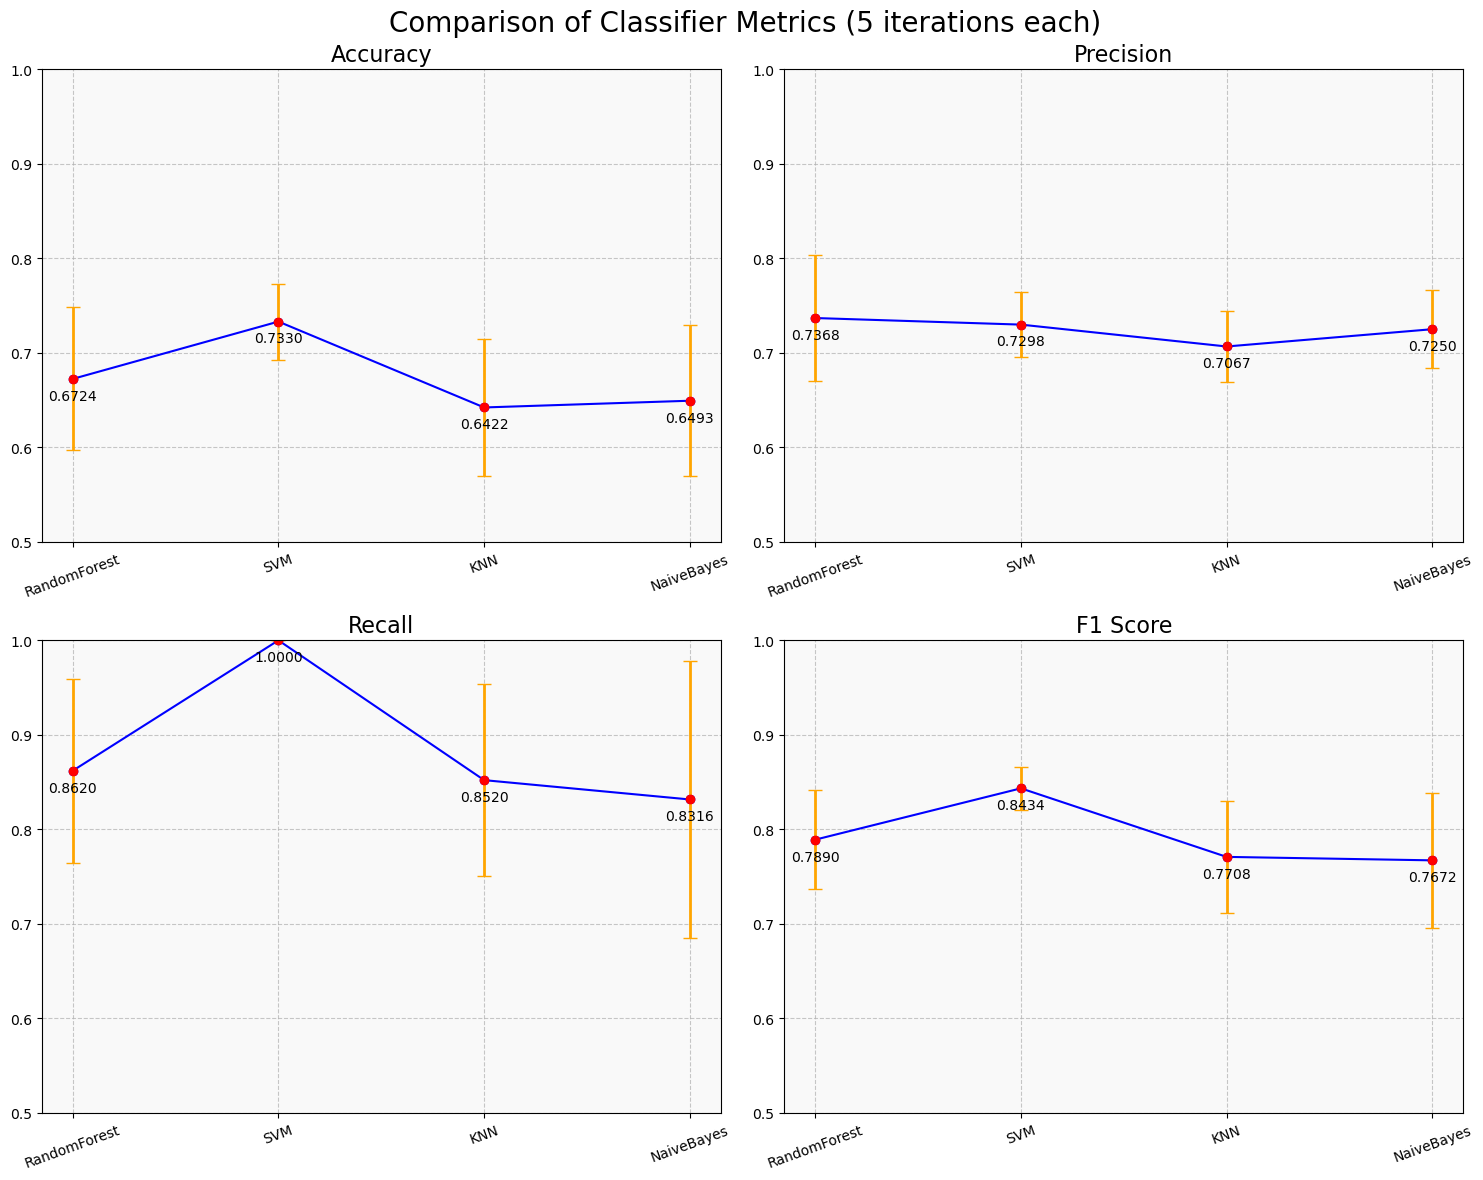

In [25]:
# Plot overall comparison
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

metrics = [
    list(mean_accuracy.values()),
    list(mean_precision.values()),
    list(mean_recall.values()),
    list(mean_f1.values()),
]
std_devs = [
    list(std_accuracy.values()),
    list(std_precision.values()),
    list(std_recall.values()),
    list(std_f1.values()),
]
titles = ["Accuracy", "Precision", "Recall", "F1 Score"]

for i, (ax, metric, std_dev, title) in enumerate(
    zip(axs.flatten(), metrics, std_devs, titles)
):
    SetUpSubPlot(ax, classifiers, metric, std_dev, title)

fig.suptitle(
    f"Comparison of Classifier Metrics ({skf_splits} iterations each)", fontsize=20
)
plt.subplots_adjust(top=0.7)
plt.tight_layout()
plt.show()

## <span style="color: yellowgreen;">9. </span> Creating and Displaying Confusion Matrices


We create and display confusion matrices for each classifier.


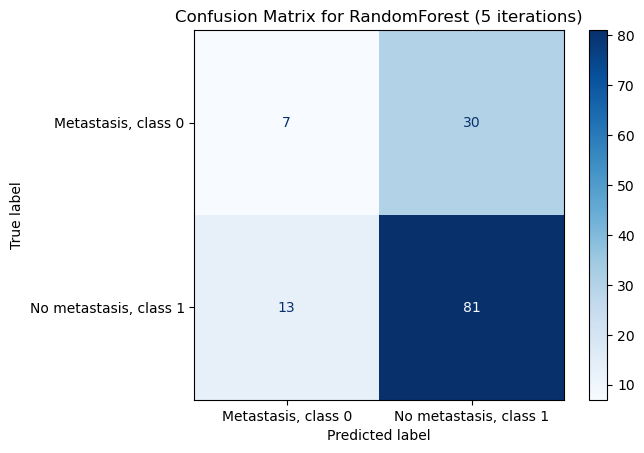

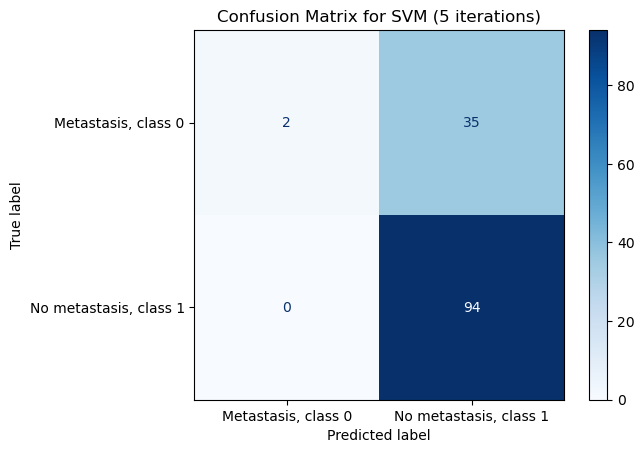

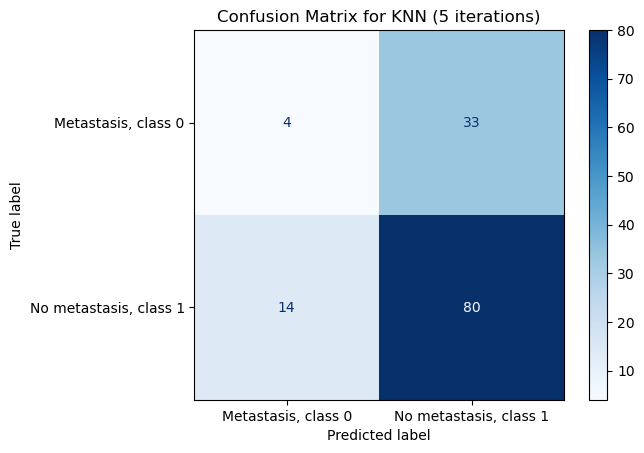

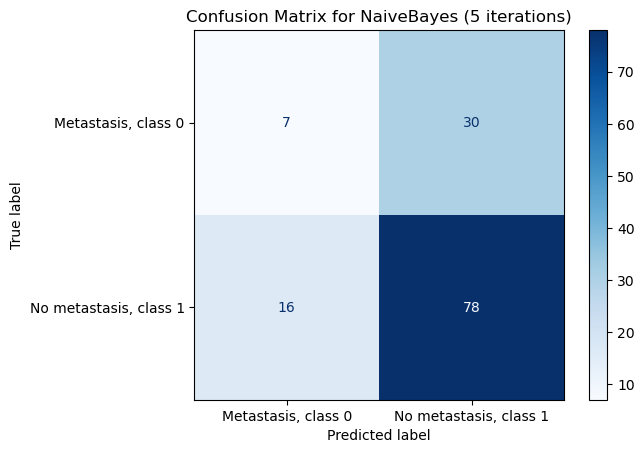

In [26]:
# Plot confusion matrices
for name in classifiers.keys():
    conf_mat = conf_matrices[name]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_mat, display_labels=TARGET_NAMES
    )
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {name} ({skf_splits} iterations)")
    plt.show()